In [2]:
restart_df = True

# run from python
import scripts.label_image 
from scripts.read_tensor_from_image_file import read_tensor_from_image_file
from scripts.load_labels import load_labels
from scripts.load_graph import load_graph
import sys
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import time
import psutil
import pandas as pd


input_height = 224
input_width = 224
input_mean = 128
input_std = 128
input_layer = "input"
output_layer = "final_result"
ARCHITECTURE = "mobilenet_1.0_224"
label_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/'+ARCHITECTURE+'_retrained_labels.txt'
model_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/'+ARCHITECTURE+'_retrained_graph.pb'
 

###############################
# iterate across series of photos 
os.chdir(r'/home/mmann1123/Dropbox/Apps/PiCameraLogger/')
rootdir = os.getcwd()

# set up storage for classifications or load existing csv of classifications
if restart_df == True: 
    df = pd.DataFrame(columns=['Path','Date','Class','Prob'])
else:
    df = pd.read_csv('/home/mmann1123/Documents/PiCameraClassifier/predicted_labels.csv', index_col=0)

for dir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == '.dropbox' or file =='predicted_labels.csv'or len(df[df['Path'].str.contains(file)])>0:
            #print(file + ' already exists in df')
            continue
        file_name = os.path.join(dir, file)
        graph = load_graph(model_file)
        t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)
        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0],
                  {input_operation.outputs[0]: t})
        results = np.squeeze(results)
        top_k = results.argsort()[-5:][::-1]
        labels = load_labels(label_file)
        image = Image.open( file_name)
        font_type = ImageFont.truetype('/home/mmann1123/Documents/Fonts/unifont-10.0.07.ttf',25)
        draw = ImageDraw.Draw(image)
        draw.text(xy =(50,50),text=labels[top_k[0]]+' '+np.array2string(results[top_k[0]]),fill=(255,255,255), font=font_type)
        #image.show()
        
        #store path class date
        file_name2 = os.path.splitext(file_name)[0]
        date_in = file_name2.split("Picapture_")[1]
        date_time = datetime.strptime(date_in, "%d_%m_%Y-%H:%M:%S")
        df = df.append({'Path': file_name, 'Date': date_time, 'Class': labels[top_k[0]], 'Prob': results[top_k[0]]}, ignore_index=True) 
        print(labels[top_k[0]], results[top_k[0]])



('car', 0.91176903)
('fedex', 0.99953473)
('car', 0.96082217)
('car', 0.96958935)
('car', 0.97734499)
('car', 0.92059386)
('car', 0.9848119)


KeyboardInterrupt: 

In [ ]:
os.chdir(r'/home/mmann1123/Documents/PiCameraClassifier/')

df.to_csv('./predicted_labels_inception.csv')

In [4]:
df.tail()

,Path,Date,Class,Prob
18048,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,2018-04-06 07:33:00,car,0.967370
18049,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,2018-04-06 10:02:00,car,0.779900
18050,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,2018-04-06 09:06:01,car,0.985861
18051,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,2018-04-06 07:24:00,fedex,0.648937
18052,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,2018-04-06 15:11:00,car,0.999943


In [13]:
df = pd.read_csv('./predicted_labels.csv',)
df = df.loc[:,['Date','Path','Class','Prob']]
     #   date_time = 

df.tail()


,Date,Path,Class,Prob
18048,2018-04-06 07:33:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,car,0.967370
18049,2018-04-06 10:02:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,car,0.779900
18050,2018-04-06 09:06:01,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,car,0.985861
18051,2018-04-06 07:24:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,fedex,0.648937
18052,2018-04-06 15:11:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/06...,car,0.999943


## FedEx Truck Counts 
Here we count the number of high probability FedEx truck based on a photo every 2 minutes. 

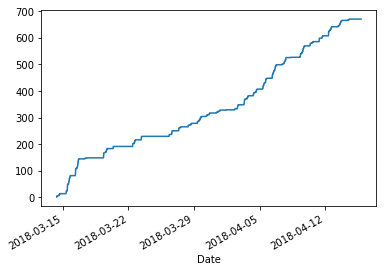

In [14]:
threshhold = 0.75
df.index =  pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M:%S")
df.sort_index(inplace=True)
fedex = df.copy()
fedex = fedex.assign(Count=pd.Series([0] * len(fedex['Date'])).values)
fedex.loc[(fedex.Prob > threshhold) & (fedex.Class == 'fedex') ,'Count' ] =1
fedex = fedex.assign(CumSum=pd.Series(fedex.Count.cumsum()  ).values)
fedex.CumSum.plot()

,Date,Path,Class,Prob,Count,CumSum,Day
Date,,,,,,,
2018-03-14 08:48:00,2018-03-14 08:48:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/14...,junk,0.452966,0,0,Wednesday
2018-03-14 08:50:00,2018-03-14 08:50:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/14...,car,0.666351,0,0,Wednesday
2018-03-14 08:52:00,2018-03-14 08:52:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/14...,junk,0.815357,0,0,Wednesday
2018-03-14 08:54:00,2018-03-14 08:54:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/14...,junk,0.414256,0,0,Wednesday
2018-03-14 08:56:00,2018-03-14 08:56:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/14...,junk,0.646124,0,0,Wednesday


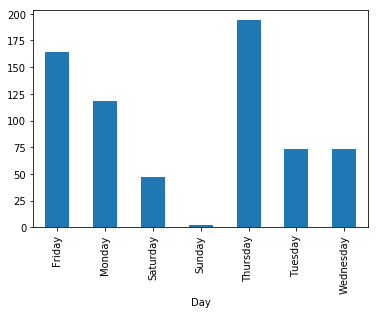

In [15]:
fedex = fedex.assign(Day=pd.Series(fedex.index.strftime('%A')).values)
fedex[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)
fedex.head()


## county by hour excluding weekends

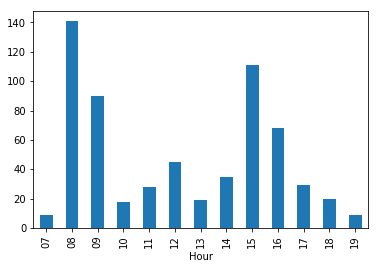

In [16]:
fedex = fedex.assign(Hour=pd.Series(fedex.index.strftime('%H')).values)
# remove weekends 
fedex = fedex.loc[(fedex.Day != "Saturday" ) & (fedex.Day != "Sunday")  ]
fedex[['Hour', 'Count']].groupby('Hour').sum().plot(kind='bar', legend=None)


## percent by hour excluding weekends


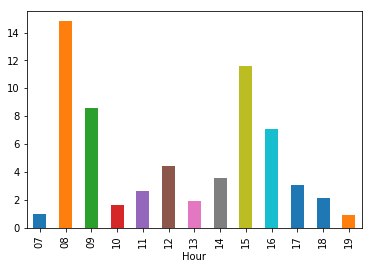

In [17]:
fedex.head(500)
fedex = fedex.assign(Ones=pd.Series([1] * len(fedex['Date'])).values)
image_h_count = fedex[['Hour', 'Ones']].groupby('Hour').sum()#.plot(kind='bar', legend=None)
fedex_h_count = fedex[['Hour', 'Count']].groupby('Hour').sum()
result = pd.concat([fedex_h_count, image_h_count], axis=1, join='inner')
result['p_fedex_image'] = result.Count / result.Ones * 100
result.p_fedex_image.plot(kind='bar')
 

# Bus Counts 
Here we count the number of high probability Buses based on a photo every 2 minutes. 

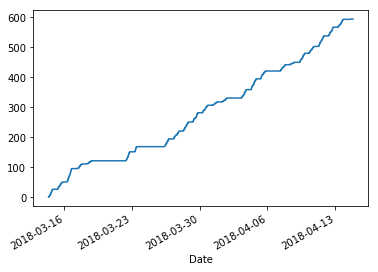

In [65]:
df.index =  pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M:%S")
df.sort_index(inplace=True)
bus = df.copy()
bus = bus.assign(Count=pd.Series([0] * len(bus['Date'])).values)
bus.loc[(bus.Prob > threshhold) & (bus.Class == 'bus') ,'Count' ] =1
bus = bus.assign(CumSum=pd.Series(bus.Count.cumsum()  ).values)
bus.CumSum.plot()
 

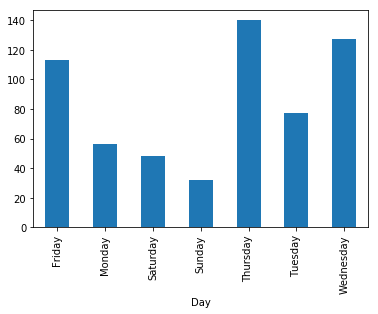

In [66]:
bus = bus.assign(Day=pd.Series(bus.index.strftime('%A')).values)
bus[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)


array([u'Wednesday', u'Thursday', u'Friday', u'Monday', u'Tuesday'], dtype=object)

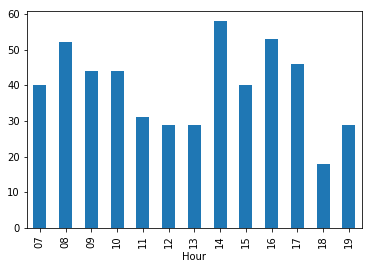

In [68]:
bus = bus.assign(Hour=pd.Series(bus.index.strftime('%H')).values)

# remove weekends 
bus = bus.loc[(bus.Day != "Saturday" ) & (bus.Day != "Sunday")  ]

bus[['Hour', 'Count']].groupby('Hour').sum().plot(kind='bar', legend=None)
bus['Day'].unique()